<a href="https://colab.research.google.com/github/Sridipta-Roy/Chest-X-Ray-Image-Classification-using-Deep-Learning/blob/main/Chest_XRay_SimpleCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q scikit-multilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 2.9 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from glob import glob
from google.colab import files, drive
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.metrics import roc_auc_score
from skmultilearn.model_selection import IterativeStratification
import warnings
warnings.filterwarnings("ignore")

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K


In [ ]:
# --- Mount Google Drive---
print("Mounting Google Drive...")
drive.mount('/content/drive')

Mounting Google Drive...
Mounted at /content/drive


## **Configuration**

In [ ]:
# --- Main Configuration ---
DATA_DIR = "/content/drive/MyDrive/Chest XRay/archive"
PROJECT_DIR = "/content/drive/MyDrive/Chest XRay"
HISTORY_CSV_PATH = os.path.join(PROJECT_DIR, "training_history.csv")
MODELS_DIR = os.path.join(PROJECT_DIR, "models")
!mkdir -p {MODELS_DIR}

METADATA_PATH = os.path.join(DATA_DIR, "Data_Entry_2017.csv")
NEW_MEDATA_PATH = os.path.join(DATA_DIR, "metadata_with_full_path.csv") # For dev purpose created a new file with image path added to the CSV

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
DROPOUT_RATE = 0.4

# For initial testing
USE_SUBSET = True
SUBSET_FRACTION = 0.5 # Use 50% of the data

SEED = 42 # Seed for reproducibility of shuffling.

## **Data Loading**

In [ ]:
# --- Load Metadata ---
#df = pd.read_csv(METADATA_PATH)
df = pd.read_csv(NEW_MEDATA_PATH)

In [ ]:
# def build_image_path_map(image_root):
#     image_path_map = {}
#     for folder in os.listdir(image_root):
#         subfolder = os.path.join(image_root, folder, "images")
#         if not os.path.isdir(subfolder):
#             continue
#         for img_file in os.listdir(subfolder):
#             if img_file.endswith(".png"):
#                 full_path = os.path.join(subfolder, img_file)
#                 image_path_map[img_file] = full_path
#     return image_path_map

# image_path_map = build_image_path_map(PROJECT_DIR)

In [ ]:
# # --- Create Full Image Paths ---
# img_name = df['Image Index']
# df['full_path'] = img_name.map(image_path_map)

In [ ]:
# # Export to csv for easy loading
# df.to_csv(os.path.join(PROJECT_DIR, "metadata_with_full_path.csv"), index=False)

In [ ]:
df = df.dropna(subset=['full_path']) # Drop rows where image file is missing
# Drop column Unnamed:11
df.drop(columns=['Unnamed: 11'], inplace=True)
print(f"Total images found: {len(df)}")

Total images found: 112118


In [ ]:
df.head(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],full_path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,/content/drive/MyDrive/Chest XRay/archive/imag...
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,/content/drive/MyDrive/Chest XRay/archive/imag...
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,/content/drive/MyDrive/Chest XRay/archive/imag...
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,/content/drive/MyDrive/Chest XRay/archive/imag...
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,/content/drive/MyDrive/Chest XRay/archive/imag...


## **Pre-processing**

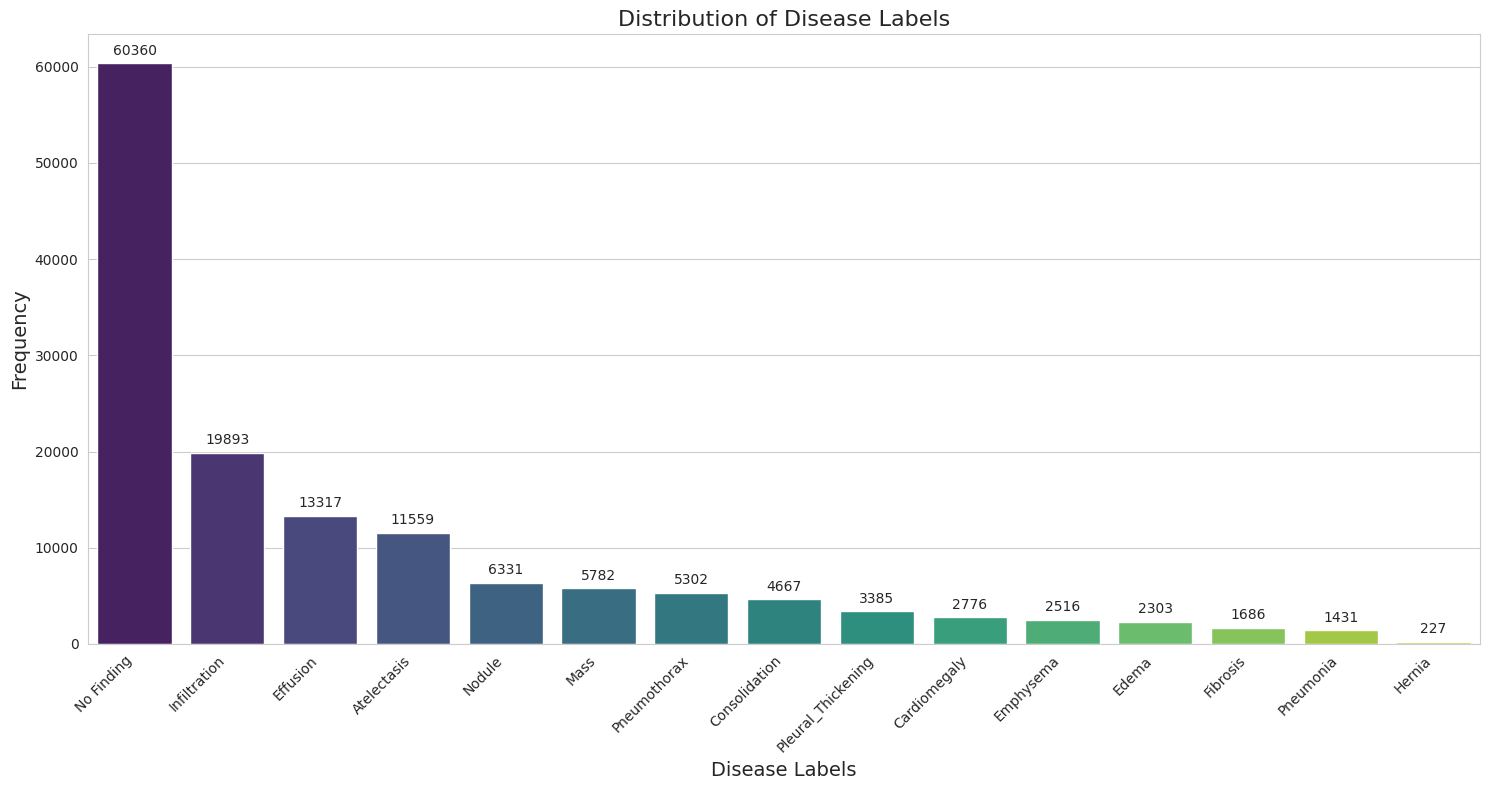

In [ ]:
label_counts = Counter()
for labels in df['Finding Labels']:
    label_counts.update(labels.split('|'))

label_counts_series = pd.Series(label_counts).sort_values(ascending=False)

# --- Plotting the Visualization ---

sns.set_style("whitegrid")
plt.figure(figsize=(15, 8))
ax = sns.barplot(x=label_counts_series.index, y=label_counts_series.values, palette='viridis', hue=label_counts_series.index, legend=False)
plt.title('Distribution of Disease Labels', fontsize=16)
plt.ylabel('Frequency', fontsize=14)
plt.xlabel('Disease Labels', fontsize=14)
plt.xticks(rotation=45, ha='right')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points',
                fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
# Replace 'No Finding' with an empty string
df['Finding Labels'] = df['Finding Labels'].str.replace('No Finding', '')

# Get unique labels and create one-hot encoded columns
all_labels = (df['Finding Labels'].str.split('|', expand=True)
              .stack()
              .str.strip()
              .unique())
all_labels = [x for x in all_labels if len(x) > 0] # Remove empty strings

print('All Labels ({}): {}'.format(len(all_labels), all_labels))

# Create one-hot encoded columns for each label
for c_label in all_labels:
    df[c_label] = df['Finding Labels'].str.contains(c_label).astype(float)

All Labels (14): ['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax', 'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation']


In [ ]:
df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],full_path,Cardiomegaly,Emphysema,Effusion,Hernia,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation
102576,00027345_000.png,Infiltration,0,27345,53,M,PA,2992,2991,0.143,0.143,/content/drive/MyDrive/Chest XRay/archive/imag...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8756,00002309_000.png,,0,2309,80,M,PA,2500,2048,0.171,0.171,/content/drive/MyDrive/Chest XRay/archive/imag...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2451,00000631_003.png,Emphysema|Pneumothorax,3,631,25,M,PA,2992,2991,0.143,0.143,/content/drive/MyDrive/Chest XRay/archive/imag...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
all_labels

['Cardiomegaly',
 'Emphysema',
 'Effusion',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Atelectasis',
 'Pneumothorax',
 'Pleural_Thickening',
 'Pneumonia',
 'Fibrosis',
 'Edema',
 'Consolidation']

In [ ]:
# Create a single labels column with all 14 binary values
df.loc[:, 'labels_vec'] = df.apply(lambda row: [row[p] for p in all_labels], axis=1)

In [ ]:
print("Labels have been multi-hot encoded.")
df[['Image Index', 'Finding Labels', 'labels_vec'] + all_labels].head()

Labels have been multi-hot encoded.


,Image Index,Finding Labels,labels_vec,Cardiomegaly,Emphysema,Effusion,Hernia,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation
0,00000001_000.png,Cardiomegaly,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#@title Multi-Label Stratified Data Splitting
print("\nSplitting data into training, validation, and test sets...")

df_to_split = df.copy()
if USE_SUBSET:
    # To make stratification effective, we sample patients first, then stratify their images
    unique_patients = df_to_split['Patient ID'].unique()
    subset_patient_ids = np.random.choice(unique_patients,
                                          size=int(len(unique_patients) * SUBSET_FRACTION),
                                          replace=False)
    df_to_split = df_to_split[df_to_split['Patient ID'].isin(subset_patient_ids)]
    print(f"Using a subset of {len(df_to_split)} images for splitting.")


Splitting data into training, validation, and test sets...
Using a subset of 56184 images for splitting.


In [ ]:
# Prepare data for the stratifier (X=features, y=labels)
X = df_to_split['full_path'].values.reshape(-1, 1)
y = np.array(df_to_split['labels_vec'].tolist())

# Split into Train (70%) and a temporary set (30%)
stratifier_traintest = IterativeStratification(n_splits=10, order=1)
train_indices, temp_indices = next(stratifier_traintest.split(X, y))

train_df = df_to_split.iloc[train_indices]
temp_df = df_to_split.iloc[temp_indices]

# Split the temporary set (30%) into Validation (10%) and Test (20%)
X_temp = temp_df['full_path'].values.reshape(-1, 1)
y_temp = np.array(temp_df['labels_vec'].tolist())

stratifier_valtest = IterativeStratification(n_splits=3, order=1) # 1/3 of temp_df for validation
val_indices, test_indices = next(stratifier_valtest.split(X_temp, y_temp))

val_df = temp_df.iloc[val_indices]
test_df = temp_df.iloc[test_indices]

print("\nData split successfully:")
print(f"Train samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")



Data split successfully:
Train samples: 50565
Validation samples: 3746
Test samples: 1873


In [ ]:
# Create final arrays for the data pipelines
X_train, y_train = train_df['full_path'].values, np.array(train_df['labels_vec'].tolist())
X_val, y_val = val_df['full_path'].values, np.array(val_df['labels_vec'].tolist())
X_test, y_test = test_df['full_path'].values, np.array(test_df['labels_vec'].tolist())

In [ ]:
#@title Create TensorFlow Data Pipeline
# --- Image Augmentation Layers ---
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.1),
  tf.keras.layers.RandomZoom(height_factor=0.1, width_factor=0.1),
  tf.keras.layers.RandomBrightness(factor=0.1),
], name="data_augmentation")

def parse_image(filepath, label):
    """Loads an image file and preprocesses it for the DenseNet model."""
    image = tf.io.read_file(filepath)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    # Normalize using ImageNet stats
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, label

def create_dataset(filepaths, labels, augment=False):
    """Creates a batched, prefetched, and optionally augmented tf.data.Dataset."""
    dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels))
    dataset = dataset.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)

    if augment:
        dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y),
                               num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Create the final datasets for training, validation, and testing
train_ds = create_dataset(X_train, y_train, augment=True)
val_ds = create_dataset(X_val, y_val)
test_ds = create_dataset(X_test, y_test)

print("Data pipelines created successfully.")

Data pipelines created successfully.


In [ ]:
# Check the output shape

# sample = train_ds.take(1)
# for images, labels in sample:
#     print("Images batch shape:", images.shape)
#     print("Labels batch shape:", labels.shape)

# **Obj 1: Model Comparison**

Model Buiding, Training and Evaluation

In [ ]:
#@title Define the Callbacks
# Callback to save the best model weights based on validation AUC
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(MODELS_DIR, "simplecnn_best.weights.h5"),
    monitor='val_auc',
    mode='max',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

# Callback to stop training early if there's no improvement
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc',
    mode='max',
    patience=5, # Stop after 5 epochs of no improvement
    verbose=1,
    restore_best_weights=True
)

print("Callbacks are ready.")

Callbacks are ready.


In [ ]:
#@title Focal Loss Fuction

# Focal Loss implementation
def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    """
    Focal Loss function for multi-label classification.
    alpha: Balances positive/negative examples.
    gamma: Modulates the easy/hard examples.
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1. - K.epsilon())

    # Calculate cross-entropy
    bce = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)

    # Calculate modulating factor for positive and negative samples
    p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
    modulating_factor = tf.pow(1.0 - p_t, gamma)

    # Calculate alpha factor
    alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)

    focal_loss = alpha_factor * modulating_factor * bce
    return K.mean(focal_loss)

In [ ]:
#@title 3.1: Build and Train the Simple CNN

def build_simple_cnn(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    outputs = Dense(num_classes, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs, name="Simple CNN")

    return model

simple_cnn_model = build_simple_cnn(input_shape=(*IMG_SIZE, 3), num_classes=len(all_labels))
simple_cnn_model.summary()

Model: "Simple CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 14)             │         3,598 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129,870 (507.30 KB)

 Trainable params: 129,870 (507.30 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print("\n--- Training Simple CNN Baseline ---")
simple_cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=focal_loss,
    metrics=[tf.keras.metrics.AUC(name='auc', multi_label=True)]
)
model_name = "Simple-CNN"
history_stage1 = simple_cnn_model.fit(
    train_ds,
    epochs=25,
    validation_data=val_ds,
    callbacks=[model_checkpoint, early_stopping]
)



--- Training Simple CNN Baseline ---
Epoch 1/25
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - auc: 0.5193 - loss: 0.0648
Epoch 1: val_auc improved from -inf to 0.54667, saving model to /content/drive/MyDrive/Chest XRay/models/simplecnn_best.weights.h5
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 1824s 1s/step - auc: 0.5193 - loss: 0.0648 - val_auc: 0.5467 - val_loss: 0.0202
Epoch 2/25
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - auc: 0.5348 - loss: 0.0181
Epoch 2: val_auc improved from 0.54667 to 0.54823, saving model to /content/drive/MyDrive/Chest XRay/models/simplecnn_best.weights.h5
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 199s 125ms/step - auc: 0.5348 - loss: 0.0181 - val_auc: 0.5482 - val_loss: 0.0207
Epoch 3/25
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - auc: 0.5388 - loss: 0.0177
Epoch 3: val_auc improved from 0.54823 to 0.54969, saving model to /content/drive/MyDrive/Chest XRay/models/simplecnn_best.weights.h5
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 198s 124ms/step - auc: 0.5388 - loss: 0.0177 - val_auc: 

In [ ]:
# Convert the history object to a Pandas DataFrame
history_stage1_df = pd.DataFrame(history_stage1.history)
history_stage1_df['epoch'] = history_stage1_df.index + 1
history_stage1_df['model'] = model_name

# Append to the CSV file, creating it if it doesn't exist
# Set header=False if the file already exists to avoid writing multiple headers
history_stage1_df.to_csv(HISTORY_CSV_PATH, mode='a', header=not os.path.exists(HISTORY_CSV_PATH), index=False)

print(f"Saved training history for {model_name} to {HISTORY_CSV_PATH}")

Saved training history for Simple-CNN to /content/drive/MyDrive/Chest XRay/training_history.csv


In [ ]:
#@title Final Evaluation on the Test Set
print("\n--- FINAL EVALUATION ON TEST SET ---")

# Load the best weights saved by the ModelCheckpoint callback
print("Loading best model weights from training...")
simple_cnn_model.load_weights(os.path.join(MODELS_DIR, "simplecnn_best.weights.h5"))

# Evaluate the model on the unseen test data
results = simple_cnn_model.evaluate(test_ds, return_dict=True, verbose=0)
print(f"\nTest Loss: {results['loss']:.4f}")
print(f"Test AUC (Keras built-in): {results['auc']:.4f}")

# Calculate the precise, macro-averaged AUC on the entire test set
print("\nCalculating precise AUC using scikit-learn...")
test_true = np.concatenate([y for x, y in test_ds], axis=0)
test_pred = simple_cnn_model.predict(test_ds)
final_auc = roc_auc_score(test_true, test_pred, average='macro')
print(f"Test AUC (scikit-learn, macro-average): {final_auc:.4f}")

# Print class-wise AUC scores to see performance on each pathology
print("\n--- Class-wise Test AUC ---")
class_auc_scores = roc_auc_score(test_true, test_pred, average=None)
for i, pathology in enumerate(all_labels):
    print(f"{pathology:>20}: {class_auc_scores[i]:.4f}")


--- FINAL EVALUATION ON TEST SET ---
Loading best model weights from training...

Test Loss: 0.0178
Test AUC (Keras built-in): 0.6546

Calculating precise AUC using scikit-learn...
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step
Test AUC (scikit-learn, macro-average): 0.6558

--- Class-wise Test AUC ---
        Cardiomegaly: 0.6838
           Emphysema: 0.5665
            Effusion: 0.7587
              Hernia: 0.5886
        Infiltration: 0.6486
                Mass: 0.5528
              Nodule: 0.5953
         Atelectasis: 0.6637
        Pneumothorax: 0.6732
  Pleural_Thickening: 0.6490
           Pneumonia: 0.7245
            Fibrosis: 0.5912
               Edema: 0.7981
       Consolidation: 0.6869


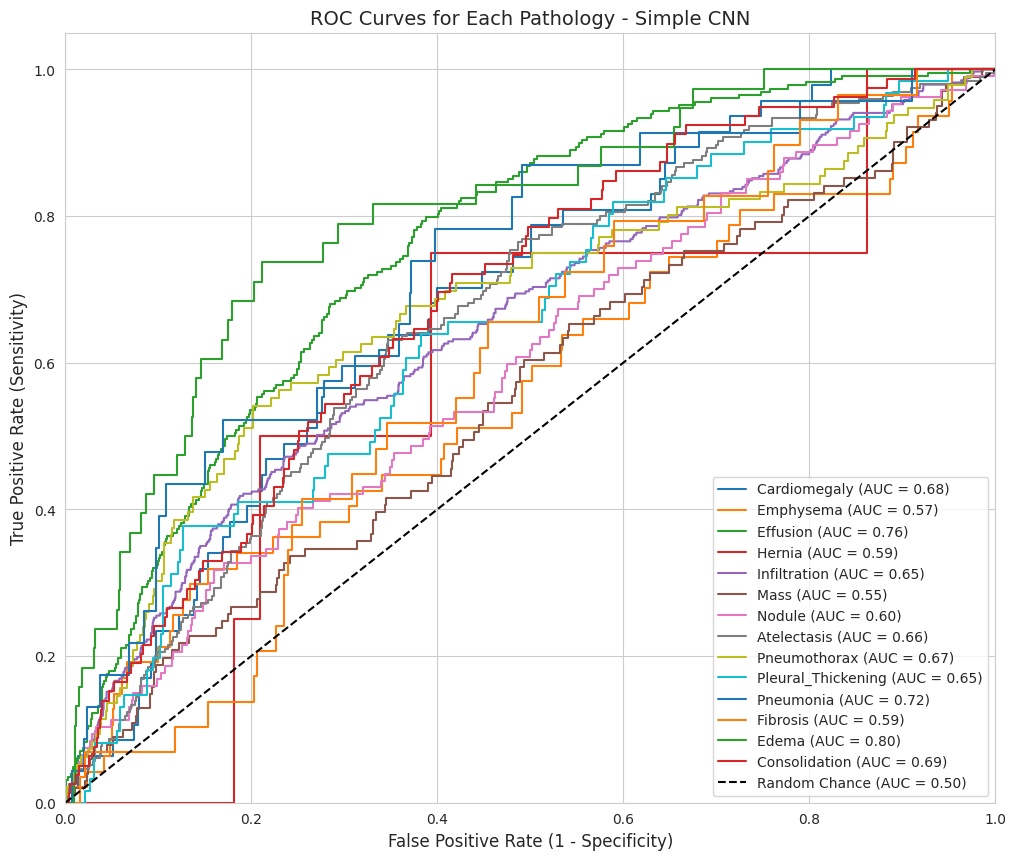

In [ ]:
#@title Plot ROC-AUC Curves for Each Class

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Set up the plot
plt.figure(figsize=(12, 10))

for i, pathology in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_true[:, i], test_pred[:, i])
    # Calculate the Area Under the Curve (AUC)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{pathology} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Chance (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12)
plt.title('ROC Curves for Each Pathology - Simple CNN', fontsize=14)

plt.legend(loc="lower right", fontsize=10)
plt.grid(True)
plt.show()